In [77]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import sys, os
import math
import seaborn as sns
import matplotlib.pyplot as plt

cd = os.path.split(os.getcwd())[0]
if cd not in sys.path:
    sys.path.append(cd)

from lib import noaa, bexarcrime
%matplotlib inline

[sauce A](https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/)

[sauce B](http://www.icpsr.umich.edu/icpsrweb/NACJD/studies/35019)

In [2]:
# using crime reports, not arrests 
crime = pd.read_csv('../data/CountyCrimeReports.tsv', sep='\t')
crime['FIPS'] = crime['FIPS_ST'] * 1000 + crime['FIPS_CTY']
crime['vcrime'] = crime['MURDER'] + crime['RAPE'] + crime['ROBBERY'] + crime['AGASSLT']
crime = crime.set_index('FIPS')
crime = crime[['COVIND', 'vcrime']]

In [3]:
edu = pd.read_excel('../data/Education.xls', skiprows=4)

# state and areas are named nicely in this dataset and will be kept for the later 'join'
# columns[-4:] include most recent data for adults eduction
# I chose the most recent because its not like the total number of HS dropouts is going to change THAT much
edu = edu[['FIPS Code', 'State', 'Area name'] + list(edu.columns[-4:])]
edu.rename(columns={'FIPS Code':'FIPS', \
                    'Area name':'County',\
                    'Percent of adults with less than a high school diploma, 2011-2015':'p_no_HS_dip', \
                    'Percent of adults with a high school diploma only, 2011-2015':'p_HS_dip',\
                    'Percent of adults completing some college or associate\'s degree, 2011-2015':'p_some_college',\
                    'Percent of adults with a bachelor\'s degree or higher, 2011-2015':'p_college_dip'}, inplace=True)
edu = edu.set_index('FIPS')

In [4]:
pop = pd.read_excel('../data/PopulationEstimates.xls', skiprows=2)

# average the columns
cols = ['POP_ESTIMATE_2010','POP_ESTIMATE_2011','POP_ESTIMATE_2012','POP_ESTIMATE_2013','POP_ESTIMATE_2014','POP_ESTIMATE_2015','POP_ESTIMATE_2016']
pop['avgpop'] = pop[cols].sum(axis=1) / len(cols)

# more averaging
cols = ['N_POP_CHG_2010','N_POP_CHG_2011','N_POP_CHG_2012','N_POP_CHG_2013','N_POP_CHG_2014','N_POP_CHG_2015','N_POP_CHG_2016']
pop['dpop/dt'] = pop[cols].sum(axis=1) / len(cols)

# only pull FIPS code, population, and dp
pop = pop[['FIPS', 'avgpop', 'dpop/dt']]
pop = pop.set_index('FIPS')

In [5]:
pov = pd.read_excel('../data/PovertyEstimates.xls', skiprows=3)
# only select poverty percentage
pov = pov[['FIPStxt', 'PCTPOVALL_2015']]
pov.rename(columns={'FIPStxt':'FIPS', 'PCTPOVALL_2015':'p_impoverished'}, inplace=True)
pov = pov.set_index('FIPS')
pov.p_impoverished = pd.to_numeric(pov.p_impoverished, errors='coerce')

In [6]:
emp = pd.read_excel('../data/Unemployment.xls', skiprows=9)

#avg unemployment
cols = ['Unemployment_rate_2007', 'Unemployment_rate_2008', 'Unemployment_rate_2009', 'Unemployment_rate_2010', 'Unemployment_rate_2011', 'Unemployment_rate_2012', 'Unemployment_rate_2013', 'Unemployment_rate_2014', 'Unemployment_rate_2015', 'Unemployment_rate_2016']
emp['p_unempl'] = emp[cols].sum(axis=1) / len(cols)

#only pull average and income
emp = emp[['FIPStxt', 'p_unempl', 'Median_Household_Income_2015']]
emp.rename(columns={'FIPStxt':'FIPS', 'Median_Household_Income_2015':'med_income'}, inplace=True)
emp = emp.set_index('FIPS')

In [7]:
df = edu.join([pop,pov,emp,crime], how='outer')
df = df.where(df.State != 'PR').dropna(how='all') ## Puerto Rico has unreliable data

#pull out nationwide data
us = df.iloc[0]
df = df.drop(0)

In [8]:
#pull out statewide data
s = [x for x in range(1000,75000,1000)]
states = df.loc[s].dropna(how='all')

# all thats left is county level data
df = df.drop(states.index)

In [9]:
#normalizing data
df['p_dpop'] = df['dpop/dt']/df['avgpop']
df['vcrime_rate'] = 100000 * df['vcrime']/df['avgpop']
df = df.drop(['dpop/dt', 'vcrime'], axis=1)

In [10]:
df.corr()

,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
p_no_HS_dip,1.000000,0.205964,-0.522557,-0.597846,-0.053616,0.683842,0.453699,-0.564831,-0.027937,-0.219500,0.194489
p_HS_dip,0.205964,1.000000,-0.313619,-0.755844,-0.311850,0.201826,0.229787,-0.471773,-0.083522,-0.460530,-0.131599
p_some_college,-0.522557,-0.313619,1.000000,0.057059,-0.066745,-0.350508,-0.240967,0.177085,0.015753,0.090325,-0.094606
p_college_dip,-0.597846,-0.755844,0.057059,1.000000,0.322327,-0.460765,-0.376099,0.684302,0.077028,0.470936,0.014413
avgpop,-0.053616,-0.311850,-0.066745,0.322327,1.000000,-0.072498,0.010381,0.240648,0.045456,0.227862,0.224276
p_impoverished,0.683842,0.201826,-0.350508,-0.460765,-0.072498,1.000000,0.584536,-0.783092,-0.088950,-0.311778,0.283291
p_unempl,0.453699,0.229787,-0.240967,-0.376099,0.010381,0.584536,1.000000,-0.477415,-0.050123,-0.233331,0.243829
med_income,-0.564831,-0.471773,0.177085,0.684302,0.240648,-0.783092,-0.477415,1.000000,0.104544,0.493735,-0.150727
COVIND,-0.027937,-0.083522,0.015753,0.077028,0.045456,-0.088950,-0.050123,0.104544,1.000000,0.097545,0.049346
p_dpop,-0.219500,-0.460530,0.090325,0.470936,0.227862,-0.311778,-0.233331,0.493735,0.097545,1.000000,0.045527


In [11]:
df.describe()

,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
count,3142.000000,3142.000000,3142.000000,3142.000000,3.142000e+03,3141.000000,3144.000000,3141.000000,3178.000000,3142.000000,3134.000000
mean,14.570306,34.750668,30.264163,20.414354,1.006548e+05,16.274817,7.008597,48600.597899,98.178380,0.000656,235.209364
std,6.640827,7.074387,5.173695,9.020906,3.222793e+05,6.465473,2.307582,12355.268681,8.258567,0.008001,200.788724
min,1.600000,7.500000,11.400000,1.900000,8.900000e+01,3.400000,2.000000,22894.000000,0.000000,-0.034183,0.000000
25%,9.500000,30.300000,26.700000,14.200000,1.101836e+04,11.500000,5.410000,40426.000000,100.000000,-0.004174,94.501027
50%,13.100000,35.100000,30.300000,18.200000,2.579986e+04,15.200000,6.920000,46800.000000,100.000000,-0.000735,185.835681
75%,18.700000,39.600000,33.800000,24.200000,6.748536e+04,19.700000,8.370000,54153.000000,100.000000,0.004469,321.753521
max,53.700000,54.800000,47.800000,78.800000,9.999961e+06,47.400000,24.970000,125900.000000,100.000000,0.093456,1800.324529


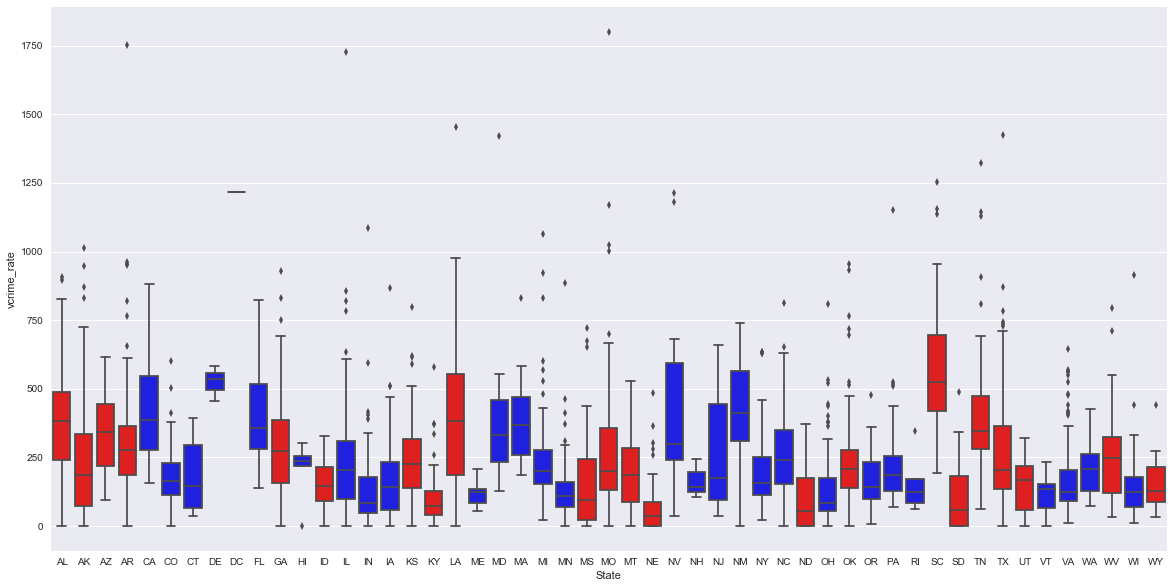

In [100]:
# According to the 2008 presidential election
blue_states =['WA', 'OR', 'CA', 'NV', 'NM', 'CO', 'MN', 'IA', 'WI', 'IL', 'IN', 'MI', 'OH', 'PA', 'NY', 'VT', 'NH', 'ME', 'MA', 'CT', 'RI', 'NJ', 'DE', 'MD', 'VA', 'NC', 'FL', 'HI']
red_states = ['ID', 'MT', 'WY', 'UT', 'AZ', 'ND', 'SD', 'NE', 'KS', 'OK', 'TX', 'MO', 'AR', 'LA', 'WV', 'KY', 'TN', 'MS', 'AL', 'GA', 'SC', 'AK']
fix, ax = plt.subplots(figsize=(20,10))
pal = {state: 'r' if state in red_states else "b" for state in df.State}
sns.boxplot(ax=ax, x='State', y='vcrime_rate', data=df, palette=pal)
#sns.boxplot(ax=ax2, x='State', y='vcrime_rate', data=df.where(df.State.isin(red_states)))

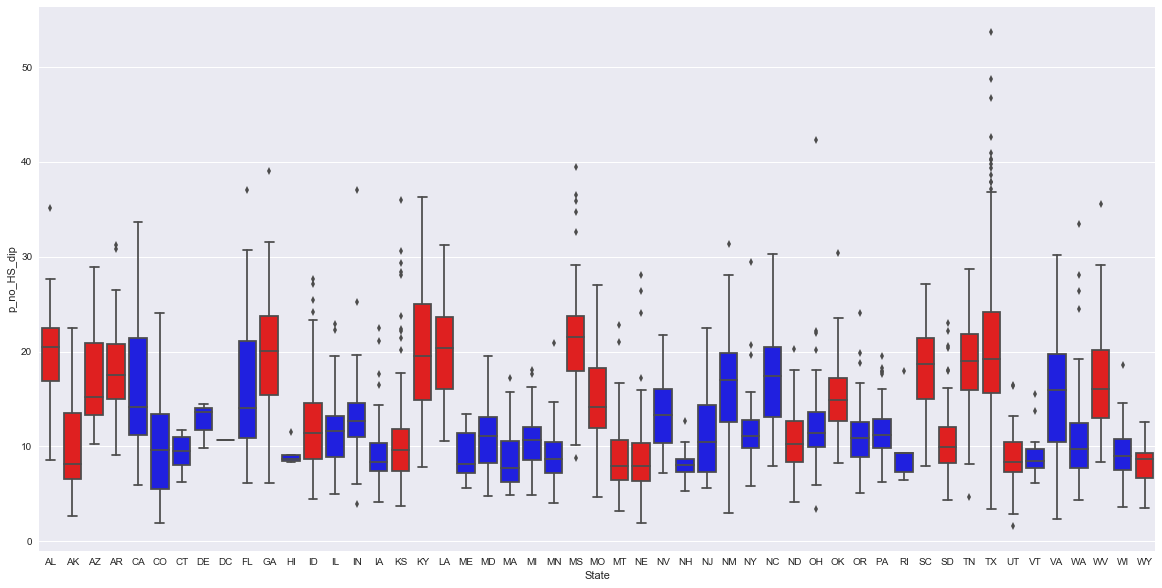

In [101]:
fix, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax=ax, x='State', y='p_no_HS_dip', data=df, palette=pal)

Graphs of factors to violent crime

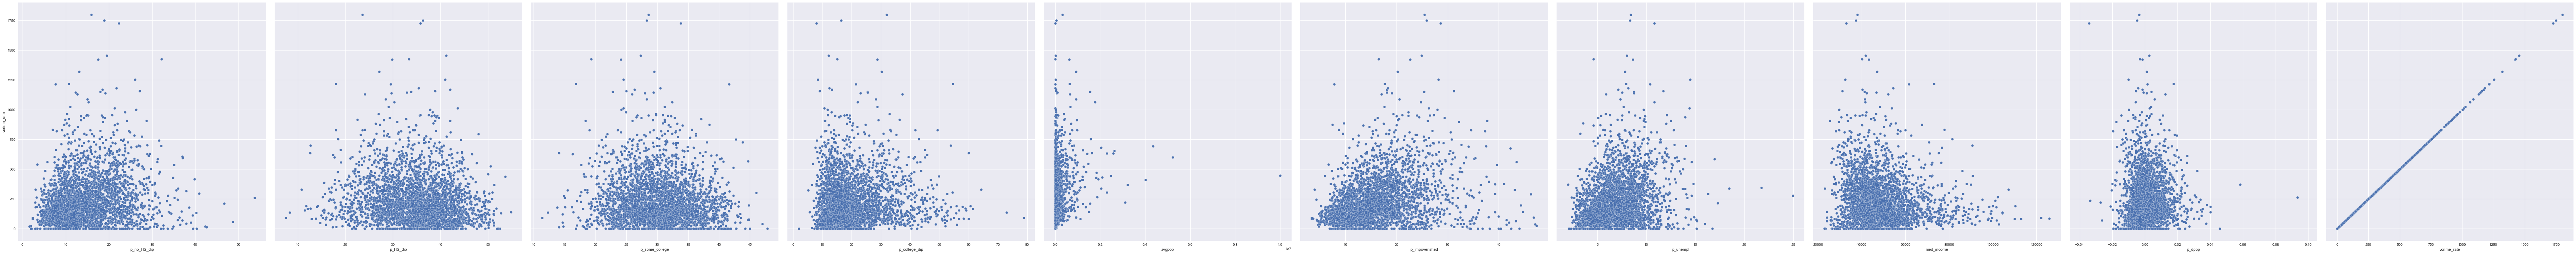

In [82]:
sns.pairplot(df, y_vars=['vcrime_rate'], x_vars=['p_no_HS_dip', 'p_HS_dip', 'p_some_college', 'p_college_dip', 'avgpop',
       'p_impoverished', 'p_unempl', 'med_income', 'p_dpop', 'vcrime_rate'], dropna=True, size=10)

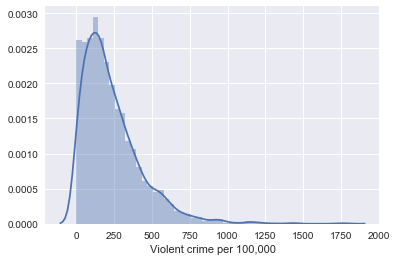

In [50]:
sns.distplot(df.vcrime_rate.dropna(), axlabel="Violent crime per 100,000")

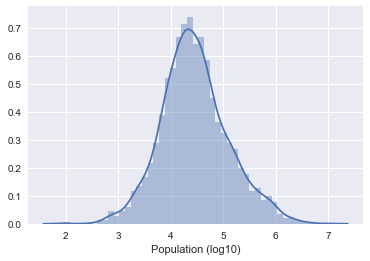

In [59]:
sns.distplot(df.avgpop.dropna().apply(np.log10), axlabel="Population (log10)")

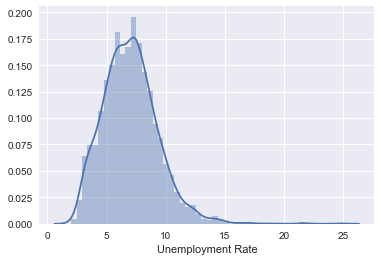

In [53]:
sns.distplot(df.p_unempl.dropna(), axlabel='Unemployment Rate')

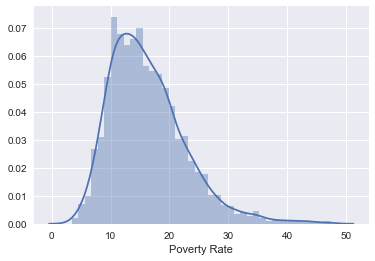

In [51]:
sns.distplot(df.p_impoverished.dropna(), axlabel="Poverty Rate")

In [27]:
# bins data into high, medium, and low (based on national quantiles) for grouping
binned = pd.DataFrame({c : pd.qcut(df[c], 3, labels=['L', 'M', 'H']) for c in df.drop(['State', 'County', 'COVIND'], axis=1).columns}).join(df[['State', 'County', 'COVIND']])

In [28]:
# apparently the worst counties to be in in Texas
# High violent crime rate, high rate of unemployment, and high populations
TX = binned.dropna(how='all').groupby(['vcrime_rate', 'p_unempl', 'avgpop'])
df.loc[TX.get_group(('H', 'H', 'H')).index].where(df.State == 'TX').dropna()

,State,County,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
FIPS,,,,,,,,,,,,,
48215,TX,Hidalgo County,37.9,23.2,22.1,16.7,816500.571429,31.1,9.29,35441.0,100.0,0.013135,316.595002
48245,TX,Jefferson County,17.0,33.3,31.3,18.4,252962.142857,16.9,8.84,47620.0,100.0,0.001356,709.197028
48291,TX,Liberty County,23.8,38.0,28.6,9.6,77840.857143,15.8,8.42,53552.0,100.0,0.011127,444.496647
48323,TX,Maverick County,40.9,22.4,25.9,10.7,56273.428571,23.9,12.33,34687.0,100.0,0.008700,296.765284
48361,TX,Orange County,11.2,40.0,34.2,14.6,83306.000000,16.1,8.67,51156.0,100.0,0.005362,354.116150


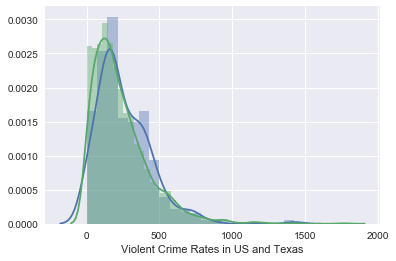

In [66]:
sns.distplot(df.where(df.State=='TX').vcrime_rate.dropna(), label="Violent Crime Rates in Texas")
sns.distplot(df.vcrime_rate.dropna(), axlabel="Violent Crime Rates in US and Texas")

In [29]:
#highest crime counties in US
# note that high city crime does not necessarily match high county crime
# eg: chicago is high crime, but it's split between 2 counties
# St Louis has the highest crime, but it's its own county, so it tops this list as well
df.where(df.avgpop > 10000).sort_values('vcrime_rate', ascending=False)[:20]

,State,County,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
FIPS,,,,,,,,,,,,,
29510,MO,St. Louis city,15.9,23.6,28.6,31.9,3.169429e+05,25.5,8.41,37948.0,100.0000,-0.003596,1800.324529
5035,AR,Crittenden County,18.9,36.3,28.3,16.4,4.986000e+04,25.9,8.31,37371.0,100.0000,-0.004776,1750.902527
22031,LA,De Soto Parish,19.5,41.2,27.3,12.1,2.695600e+04,24.9,8.01,41691.0,100.0000,0.002613,1454.221695
24510,MD,Baltimore city,17.5,29.8,24.1,28.7,6.210013e+05,22.7,8.62,43192.0,100.0000,-0.001490,1422.058247
47157,TN,Shelby County,13.1,27.1,29.5,30.2,9.352307e+05,20.2,7.82,46998.0,100.0000,0.001057,1320.957472
45069,SC,Marlboro County,26.0,41.0,24.5,8.5,2.798357e+04,28.2,14.47,32485.0,100.0000,-0.010149,1254.307374
11001,DC,District of Columbia,10.7,18.0,16.8,54.6,6.458149e+05,17.7,7.91,73115.0,100.0000,0.017565,1217.996135
29201,MO,Scott County,18.5,42.0,26.3,13.2,3.904900e+04,18.1,7.13,40285.0,100.0000,-0.001617,1170.324464
45033,SC,Dillon County,27.1,38.9,25.0,9.0,3.146329e+04,31.2,11.71,31094.0,100.0000,-0.005467,1156.903965


Group the data by violent crime rate, poverty rate, unemployment rate, and population

In [30]:
groups = ['vcrime_rate', 'p_impoverished', 'p_unempl', 'avgpop']

In [33]:
# all counties grouped by H/M/L rates of whatever
c = binned.dropna(how='all').groupby(groups[::-1])
c.count().where(c.count().State > 10).dropna().sort_values('State', ascending=False)['State'].unstack()

vcrime_rate                         H      L     M
avgpop p_unempl p_impoverished                    
H      H        H                89.0   11.0  21.0
                L                 NaN    NaN  18.0
                M                87.0   12.0  43.0
       L        H                16.0    NaN   NaN
                L                37.0   59.0  93.0
                M                47.0    NaN  21.0
       M        H                68.0    NaN  27.0
                L                41.0   46.0  79.0
                M               106.0   17.0  74.0
L      H        H                85.0   91.0  44.0
                M                14.0   34.0  28.0
       L        H                12.0   15.0  23.0
                L                29.0  210.0  77.0
                M                12.0   92.0  42.0
       M        H                28.0   28.0  40.0
                L                11.0   24.0  13.0
                M                14.0   34.0  23.0
M      H        H               153.0   60.0  73.0
                L                 NaN   18.0   NaN
                M                29.0   41.0  48.0
       L        L                21.0   81.0  51.0
                M                24.0   17.0  39.0
       M        H                54.0   23.0  46.0
                L                11.0   60.0  37.0
                M                35.0   39.0  61.0

We select counties with high rates of enemployment, violent crime, poverty, and large populations sampled using a nonrandom seed

In [34]:
# get the original values of the first row ^^^
# such that cities have high crime rate, high poverty, High unemployment, High population, etc
selection = ('H','H','H', 'H')
for x in groups:
    print("%10s " %x[:10], end='')
print('')
for x in selection:
    print("%10s " %x[:10], end='')
HHHstates = df.loc[c.get_group(selection).index]
HHHstates.where(HHHstates.vcrime_rate > 800).dropna().sample(10, random_state=15)

vcrime_rat p_impoveri   p_unempl     avgpop 
         H          H          H          H 

,State,County,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
FIPS,,,,,,,,,,,,,
42101,PA,Philadelphia County,18.0,33.8,22.8,25.4,1.552449e+06,25.4,8.74,41210.0,100.0000,0.003853,1150.827067
13095,GA,Dougherty County,19.1,29.3,32.8,18.9,9.301957e+04,29.4,9.34,34799.0,100.0000,-0.006985,929.911831
47157,TN,Shelby County,13.1,27.1,29.5,30.2,9.352307e+05,20.2,7.82,46998.0,100.0000,0.001057,1320.957472
39095,OH,Lucas County,11.6,31.2,32.9,24.2,4.364534e+05,19.5,8.26,43136.0,100.0000,-0.003053,810.624861
5069,AR,Jefferson County,15.2,38.7,28.6,17.5,7.361114e+04,26.5,8.84,36990.0,100.0000,-0.014398,953.659966
26163,MI,Wayne County,15.3,30.3,32.4,22.0,1.779158e+06,24.8,10.83,41585.0,99.6046,-0.005723,1062.862406
24510,MD,Baltimore city,17.5,29.8,24.1,28.7,6.210013e+05,22.7,8.62,43192.0,100.0000,-0.001490,1422.058247
26049,MI,Genesee County,10.7,32.8,37.1,19.3,4.160401e+05,20.5,9.80,44181.0,98.5058,-0.005897,921.305327
5035,AR,Crittenden County,18.9,36.3,28.3,16.4,4.986000e+04,25.9,8.31,37371.0,100.0000,-0.004776,1750.902527


From those counties, we selected the county seats as the cities
We looked up the latitude and longitude of them to match to NOAA's list of weather stations. We used Pythagoras' theorem to find the closest station to the city, as some cities may not have one within city limits.

In [35]:
cities = {
    'Philidelphia, PA' : (39.9526, -75.1652), #Philadelphia County
    'Albany, GA' : (31.5785, -84.1557), # Gougherty County
    'Memphis, TN' : (35.1495, -90.0490), # Shelby County and Crittenden County
    'Toledo, OH' : (41.6639, -83.5552), # Lucas County
    'Pine Bluff AR' : (34.2284, -92.0032), # Jefferson County
    'Detroit, MI' : (42.3314, -83.0458), # Wayne County
    'Baltimore, MD' : (39.2904, -76.6122), # Baltimore City
    'Flint, MI' : (43.0125, -83.6875), # Genesee County
    'St. Louis, MO' : (38.6270, -90.1994) # St. Louis City
}

In [36]:
# list of stations with location, name, and recording beginning and end dates
hist = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv')

In [ ]:
# only recent stations
hist = hist.where(hist.END > 20120101 ).dropna(how='all')

In [ ]:
def dist(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [ ]:
def format_station_code(usaf, wban):
    usafstr = str(int(usaf))
    wbanstr = str(int(wban))
    
    if len(usafstr) < 6:
        usafstr = '0'*(6-len(usafstr)) + usafstr
        
    if len(wbanstr) < 5:
        wbanstr = '0'*(5-len(wbanstr)) + wbanstr
        
    return usafstr + '-' + wbanstr

In [ ]:
stations = dict()
for city in cities.keys():
    coord = cities[city]
    mindist = 999
    minindex = 0
    for index, row in hist.iterrows():
        d = dist(coord, (row['LAT'], row['LON']))
        if (d < mindist):
            mindist = d
            minindex = index
    print('Nearest ({:^6.2f}) ISD to {:20} is {:40} at loc {}'.format(mindist, city, hist.loc[minindex]['STATION NAME'], minindex))
    stations[city] = format_station_code(hist.loc[minindex]['USAF'], hist.loc[minindex]['WBAN'])
    print('\tStation code is {}'.format(stations[city]))